# <div class="alert alert-block alert-info">An Analysis of the House and Senate Campaign Finance

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
import sklearn.tree as tree
import pydotplus
from IPython.display import Image
from collections import OrderedDict
pd.set_option('precision', 1) 
import warnings
warnings.filterwarnings('ignore')

**Install SpaCy** 
<br>(import when use)
<br>conda config --add channels conda-forge
<br>conda install spacy
<br>python -m spacy.en.download
<br>python -m spacy download en 
<br><br>**Install Gensim** 
<br>(import when use)
<br>pip install gensim
<br><br>**Install pyLDAvis** 
<br>(import when use)
<br>pip install pyldavis 

## <li>The main dataset and columns we will use here

In [2]:
df_2018=pd.read_csv('all_house_senate_2018.csv')
df_2018.head()
df_2018[['can_id','can_nam','can_off','can_off_sta','dis_pur_des','cat_des','dis_amo']].tail()
df_2018_main=df_2018[['can_id','can_nam','can_off','can_off_sta','dis_pur_des','cat_des','dis_amo']]
len(df_2018_main)

,com_id,com_nam,can_id,can_nam,ele_yea,can_off,can_off_sta,can_off_dis,lin_num,lin_ima,...,rec_zip,dis_dat,dis_amo,dis_pur_des,mem_cod,mem_tex,cat_cod,cat_des,tra_id,bac_ref_id
0,C00012229,ALASKANS FOR DON YOUNG,H6AK00045,"YOUNG, DONALD E",2018,H,AK,1,17,http://docquery.fec.gov/cgi-bin/fecimg/?201901...,...,995230112,2018-12-14,$300.00,OFFICE JANITORIAL SERVICES,NaN,NaN,NaN,NaN,B959AC6567D984383B59,NaN
1,C00012229,ALASKANS FOR DON YOUNG,H6AK00045,"YOUNG, DONALD E",2018,H,AK,1,17,http://docquery.fec.gov/cgi-bin/fecimg/?201901...,...,995196127,2018-12-05,"$3,414.98",PAYROLL TAXES,NaN,NaN,NaN,NaN,BBA8F0FB3D7014797B77,NaN
2,C00012229,ALASKANS FOR DON YOUNG,H6AK00045,"YOUNG, DONALD E",2018,H,AK,1,17,http://docquery.fec.gov/cgi-bin/fecimg/?201901...,...,995196127,2018-12-31,$2.00,BANK CHARGE,NaN,NaN,NaN,NaN,B8F94D71D2D524A189E0,NaN
3,C00012229,ALASKANS FOR DON YOUNG,H6AK00045,"YOUNG, DONALD E",2018,H,AK,1,17,http://docquery.fec.gov/cgi-bin/fecimg/?201812...,...,995012214,2018-11-16,"$7,000.00",SIGN INSTALLATION,NaN,NaN,NaN,NaN,B1CA02617CFF74D0BB21,NaN
4,C00012229,ALASKANS FOR DON YOUNG,H6AK00045,"YOUNG, DONALD E",2018,H,AK,1,17,http://docquery.fec.gov/cgi-bin/fecimg/?201812...,...,995181217,2018-10-25,"$1,394.47",MAILING POSTAGE,NaN,NaN,NaN,NaN,BA304892E27A6466BA76,NaN


,can_id,can_nam,can_off,can_off_sta,dis_pur_des,cat_des,dis_amo
1063905,S8MO00327,"CRAIN, JO",S,MO,DINNER - CAMPAIGN APPEARANCE IN HALLSVILLE,Campaign Event Expenses,$9.76
1063906,S8MO00327,"CRAIN, JO",S,MO,MILEAGE - CAMPAIGN APPEARANCE IN HALLSVILLE,Campaign Event Expenses,$150.42
1063907,S8MO00327,"CRAIN, JO",S,MO,BUSINESS CARDS,Campaign Materials,$54.30
1063908,S8MO00327,"CRAIN, JO",S,MO,LUNCH FOR CAMPAIGN VOLUNTEERS,Campaign Event Expenses,$90.41
1063909,H8ND00138,"TUTTLE, CHARLES",H,ND,LOAN REPAYMENT,NaN,$750.00


1063910

# <div class="alert alert-block alert-info">Data Cleaning 

## <li>Change disbursement amount datatype first for comming calculation

In [3]:
df_2018_main.dis_amo.replace({'\$':''},regex=True,inplace=True)
df_2018_main.dis_amo.replace({'\,':''},regex=True,inplace=True)
df_2018_main.dis_amo.replace({'\(':'-'},regex=True,inplace=True)
df_2018_main.dis_amo.replace({'\)':''},regex=True,inplace=True)
df_2018_main['dis_amo'] = pd.to_numeric(df_2018_main.dis_amo)
df_2018_main.dis_amo.sum() # 2.9billion$

2865981216.3499994

In [4]:
df_2018_main['can_nam'] = df_2018_main.can_nam.str.lstrip()
df_2018_main.can_nam.replace({'\, ':'-'},regex=True,inplace=True)
df_2018_main.can_nam.replace({'\ ':'-'},regex=True,inplace=True)

## <li> Nan value check

In [5]:
df_2018_main.isna().sum()

can_id              0
can_nam             0
can_off             0
can_off_sta         0
dis_pur_des      8013
cat_des        722868
dis_amo             0
dtype: int64

In [6]:
# Delete the 8013 nan items in 'dis_pur_des'column and form new df_2018_main, because we can never find out what they are. 
# Luckily, the portion is small.
df_2018_main.dropna(how='any', subset=['dis_pur_des'],inplace=True) 
1063910-len(df_2018_main)

# check the dis_pur_des column, there're a LOT of items to categorize!
df_2018_main.dis_pur_des.value_counts().head()
df_2018_main.dis_pur_des.nunique()

8013

TRAVEL                        54217
PAYROLL                       40601
SALARY                        38439
OFFICE SUPPLIES               28971
CREDIT CARD PROCESSING FEE    28333
Name: dis_pur_des, dtype: int64

74471

# <div class="alert alert-block alert-danger">cat_des: expense categories;<br>dis_pur_des: expense detailed purpose. <br>Different dis_pur_des are grouped under certain cat_des. <br>EG: "lodging fee at Hilton" is a dis_pur_des record, it's cat_des category is "travel expense". <br><br>There are 722,868 out of 1,06,3910 ( 68%) records without category tag (the cat_des column). So my first thought was to use current labels in cat_des to label the untagged items. But when I looked into these current labels, I found they are invalid for machine learning becasuse the accounting entries are very messy and losts of transaction purpose don't match the category labels.(see the next red block for code.) <br> <br>Besides, there are two many of cat_des labels. Some of them have overlapping concepts: "Campaign materials" can be "advertising material" or "event expense" or "administrative expense". So I prefer to set up new labels based on my research interest to do further analysis.

## <li>Data credibility check

In [7]:
# Check if the classification of the cat_des column is countable
df_2018_main.cat_des.fillna('Unknown',inplace=True)
df_2018_main.groupby('cat_des').agg({'dis_pur_des':'count','dis_amo':'sum'})

,dis_pur_des,dis_amo
cat_des,,
Administrative/Salary/Overhead Expenses,193220,3.1e+08
Advertising Expenses,25016,2.5e+08
Campaign Event Expenses,10829,9.5e+06
Campaign Materials,9723,2.3e+07
Donations,3236,5.3e+06
Loan Repayments,769,1.3e+07
Political Contributions,6344,3.5e+07
Polling Expenses,1343,1.4e+07
Refunds of Contributions,9527,1.1e+07


<div class="alert alert-block alert-warning">Clearly, there's a large part of classification missing. But first let's check if the rest of the column are accountable.
<br>In the cat_des column above, we can detect some overlaping concepts. For example, campaign materials could include advertising materials.Transfers could be donations.
<br>If we take a closer look into each categories using the codes below, we can find that acually the accountants did very sloppy job and 
the cat_des classification cannot be used for drawing meaningful conclusions.
<br>Besides, there's a category "refunds of contribution" that should be brought to attention. It's not the money candidates spent but returned. About 11 millions in total.

# <div class="alert alert-block alert-danger">I check the rows under each cat_des using the codes below and found out we cannot use the cat_des labels offered. For example, some advertising expenses are kept under other catogories instead of "Advertising expense". In that case, the total sum of each expense category cannot be right. <br><br>We also used the original labels to do machine learning, the outcome was completely absurd, which also showed that the dataset is too dirty. That' why the text clustering is brought in to explore possible classification.

df_2018_ASO=df_2018_main[df_2018_main.cat_des.str.contains('Administrative/Salary/Overhead Expenses')].groupby('dis_pur_des').\
 agg({'dis_pur_des':'count','dis_amo':'sum'}).rename(columns={'dis_pur_des':'count','dis_amo':'$amount'}).\
 sort_values(by=['count'],ascending=False)
#df_2018_ASO.head(20)

df_2018_AE=df_2018_main[df_2018_main.cat_des.str.contains('Advertising Expenses')].groupby('dis_pur_des').\
 agg({'dis_pur_des':'count','dis_amo':'sum'}).rename(columns={'dis_pur_des':'count','dis_amo':'$amount'}).\
 sort_values(by=['count'],ascending=False)
#df_2018_AE.head(20)

df_2018_CEE=df_2018_main[df_2018_main.cat_des=='Campaign Event Expenses'].groupby('dis_pur_des').\
 agg({'dis_pur_des':'count','dis_amo':'sum'}).rename(columns={'dis_pur_des':'count','dis_amo':'$amount'}).\
 sort_values(by=['count'],ascending=False)
#df_2018_CEE.head(20)

df_2018_CM=df_2018_main[df_2018_main.cat_des=='Campaign Materials'].groupby('dis_pur_des').\
 agg({'dis_pur_des':'count','dis_amo':'sum'}).rename(columns={'dis_pur_des':'count','dis_amo':'$amount'}).\
 sort_values(by=['count'],ascending=False)
#df_2018_CM.head(20)

df_2018_D=df_2018_main[df_2018_main.cat_des=='Donations'].groupby('dis_pur_des').\
 agg({'dis_pur_des':'count','dis_amo':'sum'}).rename(columns={'dis_pur_des':'count','dis_amo':'$amount'}).\
 sort_values(by=['count'],ascending=False)
#df_2018_D.head(20)

df_2018_LR=df_2018_main[df_2018_main.cat_des=='Loan Repayments'].groupby('dis_pur_des').\
 agg({'dis_pur_des':'count','dis_amo':'sum'}).rename(columns={'dis_pur_des':'count','dis_amo':'$amount'}).\
 sort_values(by=['count'],ascending=False)
#df_2018_LR.head(20)

df_2018_PC=df_2018_main[df_2018_main.cat_des=='Political Contributions'].groupby('dis_pur_des').\
 agg({'dis_pur_des':'count','dis_amo':'sum'}).rename(columns={'dis_pur_des':'count','dis_amo':'$amount'}).\
 sort_values(by=['count'],ascending=False)
#df_2018_PC.head(20)

df_2018_PE=df_2018_main[df_2018_main.cat_des=='Polling Expenses'].groupby('dis_pur_des').\
 agg({'dis_pur_des':'count','dis_amo':'sum'}).rename(columns={'dis_pur_des':'count','dis_amo':'$amount'}).\
 sort_values(by=['count'],ascending=False)
#df_2018_PE.head(20)

df_2018_RoC=df_2018_main[df_2018_main.cat_des=='Refunds of Contributions'].groupby('dis_pur_des').\
 agg({'dis_pur_des':'count','dis_amo':'sum'}).rename(columns={'dis_pur_des':'count','dis_amo':'$amount'}).\
 sort_values(by=['count'],ascending=False)
#df_2018_RoC.head(20)

df_2018_SFE=df_2018_main[df_2018_main.cat_des=='Solicitation and Fundraising Expenses'].groupby('dis_pur_des').\
 agg({'dis_pur_des':'count','dis_amo':'sum'}).rename(columns={'dis_pur_des':'count','dis_amo':'$amount'}).\
 sort_values(by=['count'],ascending=False)
#df_2018_SFE.head(20)

df_2018_T=df_2018_main[df_2018_main.cat_des=='Transfers'].groupby('dis_pur_des').\
 agg({'dis_pur_des':'count','dis_amo':'sum'}).rename(columns={'dis_pur_des':'count','dis_amo':'$amount'}).\
 sort_values(by=['count'],ascending=False)
#df_2018_T.head(20)

df_2018_TE=df_2018_main[df_2018_main.cat_des=='Travel Expenses'].groupby('dis_pur_des').\
 agg({'dis_pur_des':'count','dis_amo':'sum'}).rename(columns={'dis_pur_des':'count','dis_amo':'$amount'}).\
 sort_values(by=['count'],ascending=False)
#df_2018_TE.head(20)

# <div class="alert alert-block alert-info"> Unsupervised Topic Clustering

## <li>Throw out refund money

In [8]:
#the cat_des "refunds of contributions"
df_2018_main_RoC=df_2018_main[df_2018_main.cat_des=='Refunds of Contributions']
throwout = list(df_2018_main_RoC.dis_pur_des)
wholedata = list(df_2018_main.dis_pur_des)
rest = list(set(wholedata)^set(throwout))
df_2018_main = df_2018_main[df_2018_main.dis_pur_des.isin(rest)]

# dis_pur_des have "refund|return|memo|void"
df_2018_main['dis_purpose']=df_2018_main.dis_pur_des.str.lower()
df_2018_main_RoC2 = df_2018_main[df_2018_main.dis_purpose.str.contains('refund|return|memo|void')]
throwout2 = list(df_2018_main_RoC2.dis_purpose)
wholedata2 = list(df_2018_main.dis_purpose)
rest2 = list(set(wholedata2)^set(throwout2))
df_2018_main = df_2018_main[df_2018_main.dis_purpose.isin(rest2)]

#delete negative amount in the dataset
df_2018_main_neg = df_2018_main[df_2018_main.dis_amo < 0]
throwout3 = list(df_2018_main_neg.dis_amo)
wholedata3 = list(df_2018_main.dis_amo)
rest3 = list(set(wholedata3)^set(throwout3))
df_2018_main = df_2018_main[df_2018_main.dis_amo.isin(rest3)]

len(df_2018_main)

973158

## <li>Get text tokens
reference https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21

In [9]:
# Get token list "lda_tokens"
import spacy
spacy.load('en')
from spacy.lang.en import English
parser = English()

def tokenize(text): 
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace(): #skip space
            continue
        elif token.like_num: # delete numbers
            continue
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

# Get the puntuations set
import string
en_punct = set(string.punctuation)

# Get the stop words set
import nltk
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

# Get the tokens for LDA analysis (function)
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

def get_lemma(word):
    return WordNetLemmatizer().lemmatize(word) 

def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if token not in en_punct] # delete punctuations
    tokens = [token for token in tokens if len(token) > 1] # at least 2 letters consist a word
    tokens = [token for token in tokens if token not in en_stop] # delete stop words
    tokens = [get_lemma(token) for token in tokens] # delete word variants for accurate result
    return tokens

# Import data for LDA analysis and return text_data
import random
text_data = []
for line in df_2018_main['dis_pur_des']:
    tokens = prepare_text_for_lda(line)
    if random.random() > .99:
        #print(tokens)
        text_data.append(tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhanghuishan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/zhanghuishan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## <li>Cluster topics

In [10]:
from gensim import corpora 
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

import gensim # package for topic modeling
NUM_TOPICS = 5 # trial number based on understanding of the data file & research aims, we can lock down this number before presentation
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=20)
ldamodel.save('model.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.123*"expense" + 0.093*"event" + 0.072*"food" + 0.060*"travel"')
(1, '0.188*"service" + 0.064*"campaign" + 0.048*"fundraising" + 0.039*"consultant"')
(2, '0.227*"fee" + 0.114*"card" + 0.110*"credit" + 0.108*"processing"')
(3, '0.132*"payroll" + 0.102*"consulting" + 0.088*"salary" + 0.064*"advertising"')
(4, '0.135*"supply" + 0.132*"office" + 0.069*"tax" + 0.062*"payroll"')


<div class="alert alert-block alert-warning">From the result above, we could see the model returned us 5 topics with different focuses.
<br>We could have a rough ideas about the topic classification of all the disbursement items:
<br>To validate the result, we bring in pyLDAvis tool to analyze the model outcome.

## <li>Topic visualization

In [11]:
#if you see the circles are overlaping, run the codes below several times untill you get a perfect, unoverlapping map to present.
#if you can't see the map, type in this command below in jupiter environment terminal:
# pip install jupyter_contrib_nbextensions && jupyter contrib nbextension install --user

dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model.gensim')
import pyLDAvis.gensim 
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display) 

<div class="alert alert-block alert-warning">From the intertopic distance map above, we could see the model separated the disbursement items quite well.
<br> The classification above has less overlaping now than the classification in the original dataset.
<br> But we need to notice that if we run the codes several times, each time we get different clustering results.
<br> To make the classification more accurate for further prediction research and analysis, I will bring in the rule-based classification method to tag all the items.

# <div class="alert alert-block alert-danger">Even though the model above could give us a rough idea of the  expense purposes (dis_pur_des) text group, the outcome is unstable and not accurate enought. <br><br>I read some blogs about how to decide number of groups in the gensim. Turns out that even there are quatitative method to test the rationality, many people are still manually setting up a random group number. <br><br>Of course it's a less rigorous approach, but I believe going too far on the Gensim for this project at the moment is not a very wise strategy. <br><br>So a rule-based classification method came into my mind, we could use code to tag all dis_pur_des rows. But to give a correct tag to each row based on it's meanning and significance is not an easy task for a rookie like me. <br><br>I wrote a long paragraph of codes to do the tagging, deleted really messy entries(several purpose for one sum of money), ambiguous records(no one knows what the record means...), and some long-tail records with occurance under 10 and amount under 100k. <br><br>Finally I got a clean data set of more than 800k rows for machine learning.<br><br> However, I got to admit that this is not an ideal approach to do the tagging. Could you please give me some advice on how to do the work in a smarter way? Thank you very much!

# <div class="alert alert-block alert-info"> Rule-Based Topic Classification

### Based on my personal understanding of the dataset and political campaign activites, I want to categorize the disbursement items by the following elements to reveal the actions taken by the candidates and campaign teams. I want to find out which elements contribute more to winning the election.
### **"People Business"**
**Networking**:  the effort to find supporters; 
<br>**Paycheck**:  how much they pay their staff;
<br>**Eat**:  as in a bestseller book title, "don't eat alone"- does dinning together matter? 
<br>**Brain**: how much think tank(consultants, researchers, data analysts, polling analysts) matters?   

###  **"Service and Expense"**
**Advertising**: this might be the largest expense during a campaign, can we dig deeper into different types of ads? media/digita/...    
**Operation cost**: the daily cost of running a campaign team;
<br>**Travel**:  how much visits matters? 
    
###  **"Capital Game"** 
**Finance**: this reveals all the financial resources candidates leveraged  

## <li>Tag rows based on keywords

In [12]:
df_2018_main['networking']=df_2018_main.dis_purpose.str.contains\
                    ('event|catering|gift|gifts|donation|contribution|canvassing|petition|ticket|tickets|sponsorship|membership|vote')*1
df_2018_main['paycheck']=df_2018_main.dis_purpose.str.contains\
                    ('payroll|payrolls|salary|salaries|wage|wages|intern|per diem|stipend|staff|worker|manager|analyst|fundraiser|\
                    |labor|representative')*1
df_2018_main['eat']=df_2018_main.dis_purpose.str.contains\
                    ('food|beverage|drink|drinks|dinner|breakfast|meal|meals|lunch|refreshment')*1
df_2018_main['brain']=df_2018_main.dis_purpose.str.contains\
                    ('polling|poll|survey|consultant|consulting|consult|research|data|legal services|compliance services|\
                    |campaign management|strategy')*1
#cannot believe they pay 336 millions for these shits.
df_2018_main['advertising']=df_2018_main.dis_purpose.str.contains\
                    ('media|advertising|ad|advertisement|ads|online|digital|facebook|face book|direct mail|sign|signs|marketing|\
                    |video production|photography|internet advertising')*1
df_2018_main['operationcost']=df_2018_main.dis_purpose.str.contains\
                    ('office|telephone|phone|cellphone|call|calls|rent|rental|printing|print|\
                    |shipping|postage|software|fee|fees|t-shirt|t-shirts|supplies|credit card processing fee|credit card processing fees|\
                    |stickers|design|brochures|flowers|expense|expenses|utilities|subscription|bank charge|internet service|\
                    |email service|delivery|storage|website|internet|web|materials|tax|telecommunication|service charge|stamps|\
                    |cc processing|bank charges|mailing|email hosting|computer|wireless|telecom|security|equipment|processing|\
                    |credit card processing fee|credit card fee|insurance|accounting services|accounting')*1
df_2018_main['travel']=df_2018_main.dis_purpose.str.contains\
                    ('travel|hotel|airfare|gas|gasoline|fuel|car|transportation|cab|taxi|parking|mileage|lodging|ride|train|toll')*1
df_2018_main['finance']=df_2018_main.dis_purpose.str.contains\
                    ('fundraising|fundraiser|loan|debt|repayment|repay|transfer|transfers')*1                 
df_2018_main['sum']=df_2018_main.networking+df_2018_main.paycheck+df_2018_main.eat+df_2018_main.brain\
                    +df_2018_main.advertising+df_2018_main.operationcost+df_2018_main.travel+df_2018_main.finance

In [13]:
df_2018_main['sum'].value_counts()

1    703639
2    208284
0     45194
3     14546
4      1380
5       104
6        11
Name: sum, dtype: int64

## <li>Make adjustments to make sure each row only have one tag

In [14]:
# sum-0 type: add more key words to the tagging codes above (already added)
df_2018_main_0 = df_2018_main[df_2018_main['sum'] == 0]
df_2018_main_0.groupby('dis_purpose').agg({'dis_purpose':'count','dis_amo':'sum'}).\
     rename(columns={'dis_purpose':'count','dis_amo':'$amount'}).sort_values(by=['count'],ascending=False).head()

# sum-4/5/6 type: delete them, they put two many disbursement categories under one items, we cannot allocate the $amount to specific uses
df_2018_main_4 = df_2018_main[df_2018_main['sum'] == 4]
df_2018_main_4.groupby('dis_purpose').agg({'dis_purpose':'count','dis_amo':'sum'}).\
     rename(columns={'dis_purpose':'count','dis_amo':'$amount'}).sort_values(by=['count'],ascending=False).head()

df_2018_main_5 = df_2018_main[df_2018_main['sum'] == 5]
df_2018_main_5.groupby('dis_purpose').agg({'dis_purpose':'count','dis_amo':'sum'}).\
     rename(columns={'dis_purpose':'count','dis_amo':'$amount'}).sort_values(by=['count'],ascending=False).head()

df_2018_main_6 = df_2018_main[df_2018_main['sum'] == 6]
df_2018_main_6.groupby('dis_purpose').agg({'dis_purpose':'count','dis_amo':'sum'}).\
     rename(columns={'dis_purpose':'count','dis_amo':'$amount'}).sort_values(by=['count'],ascending=False).head()

,count,$amount
dis_purpose,,
reimbursement (vendors that aggregate over $200 listed below),800,6.8e+05
see below,690,5.1e+06
reimbursement(vendors that aggregate over $200 listed below),506,3.9e+05
reimbursement - see below if itemized,398,2.6e+05
dues,386,2.4e+06


,count,$amount
dis_purpose,,
fundraiser catering expense,254,194184.3
fundraiser event meals,82,80220.4
"fundraising event exp-signage, printing",68,70707.3
fundraising event expense - food & beverage,63,103573.7
fundraiser meal expense,51,66435.6


,count,$amount
dis_purpose,,
"fundraising expenses, travel, catering & meals",5,45309.4
chase card: fundraiser event - food and beverage,4,2242.8
fundraising consulting/catering/facility rental/travel,4,45491.1
fundraising consulting catering shipping transportation,3,31900.7
fundraising consulting/event catering/travel/shipping,3,44644.4


,count,$amount
dis_purpose,,
fundraising consulting/catering/facility rental/travel/office supplies/delivery service/food/beverag,2,56448.5
"airfare, data service, meals with constituents, payroll software, online software and maintenance",1,4045.1
fundraising consulting / catering / food/beverage / travel / postage,1,23926.2
fundraising consulting food/beverage shipping transportation event gift,1,23940.6
"fundraising consulting, event meal, postage & travel reimbursements",1,9878.7


In [15]:
throwout0 = list(df_2018_main_0.dis_purpose)
wholedata0 = list(df_2018_main.dis_purpose)
rest0 = list(set(wholedata0)^set(throwout0))
df_2018_main = df_2018_main[df_2018_main.dis_purpose.isin(rest0)]

throwout4 = list(df_2018_main_4.dis_purpose)
wholedata4 = list(df_2018_main.dis_purpose)
rest4 = list(set(wholedata4)^set(throwout4))
df_2018_main = df_2018_main[df_2018_main.dis_purpose.isin(rest4)]

throwout5 = list(df_2018_main_5.dis_purpose)
wholedata5 = list(df_2018_main.dis_purpose)
rest5 = list(set(wholedata5)^set(throwout5))
df_2018_main = df_2018_main[df_2018_main.dis_purpose.isin(rest5)]

throwout6 = list(df_2018_main_6.dis_purpose)
wholedata6 = list(df_2018_main.dis_purpose)
rest6 = list(set(wholedata6)^set(throwout6))
df_2018_main = df_2018_main[df_2018_main.dis_purpose.isin(rest6)]

In [16]:
df_2018_main.groupby('sum').agg({'sum':'count','dis_amo':'sum'}).\
     rename(columns={'sum':'count','dis_amo':'$amount'}).sort_values(by=['count'],ascending=False)

,count,$amount
sum,,
1,703639,2.2e+09
2,208284,4.4e+08
3,14546,5.3e+07


In [17]:
# sum-3 type: manually retag the significant part and 
# delete the items with more than one purposes/insignificant $amount(less than 100k)/occurrance (less than 10)

df_2018_main.loc[df_2018_main['dis_purpose'] == 'internet marketing', 'paycheck'] = 0
df_2018_main.loc[df_2018_main['dis_purpose'] == 'internet marketing', 'operationcost'] = 0
df_2018_main.loc[df_2018_main['dis_purpose'] == 'internet ads', 'paycheck'] = 0
df_2018_main.loc[df_2018_main['dis_purpose'] == 'internet ads', 'operationcost'] = 0

df_2018_main.loc[df_2018_main.dis_purpose.str.contains('internet advertising and services'), 'paycheck'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('internet advertising and services'), 'operationcost'] = 0

df_2018_main.loc[df_2018_main.dis_purpose.str.contains('consult'), 'networking'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('consult'), 'paycheck'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('consult'), 'eat'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('consult'), 'finance'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('consult'), 'advertising'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('consult'), 'operationcost'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('consult'), 'travel'] = 0

df_2018_main.loc[df_2018_main.dis_purpose.str.contains('fundrais'), 'networking'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('fundrais'), 'paycheck'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('fundrais'), 'eat'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('fundrais'), 'brain'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('fundrais'), 'advertising'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('fundrais'), 'operationcost'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('fundrais'), 'travel'] = 0

df_2018_main.loc[df_2018_main.dis_purpose.str.contains('processing'), 'networking'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('processing'), 'paycheck'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('processing'), 'eat'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('processing'), 'brain'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('processing'), 'advertising'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('processing'), 'finance'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('processing'), 'travel'] = 0

df_2018_main.loc[df_2018_main.dis_purpose.str.contains('advertis'), 'networking'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('advertis'), 'paycheck'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('advertis'), 'eat'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('advertis'), 'brain'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('advertis'), 'operationcost'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('advertis'), 'finance'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('advertis'), 'travel'] = 0

df_2018_main.loc[df_2018_main.dis_purpose.str.contains('internet consulting'), 'paycheck'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('internet consulting'), 'brain'] = 0

df_2018_main.loc[df_2018_main.dis_purpose.str.contains('per diem petition carrier'), 'paycheck'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('per diem petition carrier'), 'travel'] = 0

df_2018_main.loc[df_2018_main.dis_purpose.str.contains('administrative/salary/overhead expenses'), 'paycheck'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('administrative/salary/overhead expenses'), 'advertising'] = 0

df_2018_main.loc[df_2018_main.dis_purpose.str.contains('online contribution fees'), 'networking'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('online contribution fees'), 'advertising'] = 0

df_2018_main.loc[df_2018_main.dis_purpose.str.contains('digital consulting/web service'), 'brain'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('digital consulting/web service'), 'advertising'] = 0

df_2018_main.loc[df_2018_main.dis_purpose.str.contains('food for fundraiser'), 'paycheck'] = 0 ##

df_2018_main.loc[df_2018_main.dis_purpose.str.contains('food & beverage'), 'networking'] = 0 ##
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('food & beverage'), 'operationcost'] = 0

df_2018_main.loc[df_2018_main.dis_purpose.str.contains('event meal expense'), 'networking'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('event meal expense'), 'operationcost'] = 0

df_2018_main.loc[df_2018_main.dis_purpose.str.contains('cable/internet'), 'paycheck'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('cable/internet'), 'travel'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('internet/cable'), 'paycheck'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('internet/cable'), 'travel'] = 0

df_2018_main.loc[df_2018_main.dis_purpose.str.contains('online /credit card payment fees'), 'travel'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('online /credit card payment fees'), 'advertising'] = 0

df_2018_main.loc[df_2018_main.dis_purpose.str.contains('payroll administration fees'), 'operationcost'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('payroll administration fees'), 'advertising'] = 0

df_2018_main.loc[df_2018_main.dis_purpose.str.contains('salary/fee - administrative support'), 'operationcost'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('salary/fee - administrative support'), 'advertising'] = 0

df_2018_main.loc[df_2018_main.dis_purpose.str.contains('staff expenses: campaign management'), 'operationcost'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('staff expenses: campaign management'), 'paycheck'] = 0

df_2018_main.loc[df_2018_main.dis_purpose.str.contains('travel expenses - airline tickets'), 'networking'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('travel expenses - airline tickets'), 'operationcost'] = 0

df_2018_main.loc[df_2018_main.dis_purpose.str.contains('voter database software'), 'networking'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('voter database software'), 'brain'] = 0

df_2018_main['sum']=df_2018_main.networking+df_2018_main.paycheck+df_2018_main.eat+df_2018_main.brain\
                    +df_2018_main.advertising+df_2018_main.operationcost+df_2018_main.travel+df_2018_main.finance

In [18]:
df_2018_main_3 = df_2018_main[df_2018_main['sum'] == 3]
df_2018_main_3_filter=df_2018_main_3.groupby('dis_purpose').agg({'dis_purpose':'count','dis_amo':'sum'}).\
     rename(columns={'dis_purpose':'count','dis_amo':'$amount'})
df_2018_main_3_filter[(df_2018_main_3_filter['$amount']>100000)&(df_2018_main_3_filter['count']>10)]

,count,$amount
dis_purpose,,


In [19]:
throwout3 = list(df_2018_main_3.dis_purpose)
wholedata3 = list(df_2018_main.dis_purpose)
rest3 = list(set(wholedata3)^set(throwout3))
df_2018_main = df_2018_main[df_2018_main.dis_purpose.isin(rest3)]

In [20]:
len(df_2018_main)

923417

In [21]:
# sum-2 type: manually retag the significant part and 
# delete the items with more than one purposes/insignificant $amount(less than 100k)/occurrance (less than 10)

df_2018_main.loc[df_2018_main.dis_purpose.str.contains('accounting'), 'advertising'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('accounting'), 'brain'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('accounting'), 'networking'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('accounting'), 'paycheck'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('accounting'), 'eat'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('accounting'), 'finance'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('accounting'), 'travel'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('ad expense'), 'operationcost'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('001 administrative/salary/overhead'), 'paycheck'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('admin/office expense reimbursement'), 'advertising'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('payroll'), 'operationcost'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('credit card fee'), 'operationcost'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('direct mail'), 'operationcost'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('travel expense'), 'operationcost'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('travel'), 'paycheck'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('event'), 'operationcost'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('event'), 'eat'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('credit card merchant fee'), 'travel'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('media expense'), 'operationcost'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('polling expense'), 'operationcost'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('printing & design services'), 'advertising'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('cable tv ad'), 'travel'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('catering/meals'), 'networking'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('catering'), 'operationcost'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('voter survey'), 'networking'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('web ads'), 'operationcost'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('web design'), 'advertising'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('graphic design'), 'advertising'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('design services'), 'advertising'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('car rental'), 'operationcost'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('rental car'), 'operationcost'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('media production'), 'operationcost'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('campaign management fee'), 'operationcost'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('media strategy'), 'brain'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('campaign marketing strategy services'), 'brain'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('voter data'), 'networking'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('print ad'), 'operationcost'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('office - net salary'), 'operationcost'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('contribution made'), 'advertising'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('design & printing services'), 'advertising'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('digital media fee'), 'operationcost'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('internet service'), 'paycheck'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('candidate and staff travel'), 'paycheck'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('data subscription'), 'operationcost'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('meal expense'), 'operationcost'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('campaign food and beverage expense'), 'operationcost'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('internet'), 'paycheck'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('petition signature collection'), 'advertising'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('website hosting - digital images'), 'advertising'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('adp wage pay'), 'advertising'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('database'), 'brain'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('credit card debt'), 'travel'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('workers compensation insurance'), 'operationcost'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('lodging expense'), 'operationcost'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('gross wages. payment made through idm payroll solutions, 1910 olympic blvd, suite 235, walnut creek,'), 'advertising'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('office - net wages'), 'operationcost'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('cartridges'), 'travel'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('cartridges'), 'operationcost'] = 1
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('credit card payment'), 'travel'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('credit card payment'), 'finance'] = 1
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('card print'), 'travel'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('print card'), 'travel'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('card print'), 'advertising'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('website design'), 'advertising'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('salary'), 'operationcost'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('web service/media'), 'operationcost'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('collateral materials- signs'), 'operationcost'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('staff lodging'), 'paycheck'] = 0
df_2018_main['sum']=df_2018_main.networking+df_2018_main.paycheck+df_2018_main.eat+df_2018_main.brain\
                    +df_2018_main.advertising+df_2018_main.operationcost+df_2018_main.travel+df_2018_main.finance

In [22]:
df_2018_main_2 = df_2018_main[df_2018_main['sum'] == 2]
df_2018_main_2_filter = df_2018_main_2.groupby('dis_purpose').agg({'dis_purpose':'count','dis_amo':'sum'}).\
     rename(columns={'dis_purpose':'count','dis_amo':'$amount'})
df_2018_main_2_filter[(df_2018_main_2_filter['$amount']>100000) & (df_2018_main_2_filter['count']>10)].\
sort_values(by='$amount', ascending=False)

,count,$amount
dis_purpose,,
federal contribution - 30114(a)(4) transfer,17,557500.0


In [23]:
df_2018_main.groupby('sum').agg({'sum':'count','dis_amo':'sum'}).\
     rename(columns={'sum':'count','dis_amo':'$amount'}).sort_values(by=['count'],ascending=False)

,count,$amount
sum,,
1,869580,2.5e+09
2,28695,7.6e+07
0,25142,1.1e+08


In [24]:
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('fundrais'),'finance'] = 1
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('processing'),'finance'] = 1
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('database software'),'brain'] = 0
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('database'),'operationcost'] = 1
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('database software'),'operationcost'] = 1
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('database services'),'operationcost'] = 1
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('consulting'),'brain'] = 1
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('advertising'),'advertising'] = 1
df_2018_main.loc[df_2018_main.dis_purpose.str.contains('event expense'),'networking'] = 1

df_2018_main['sum']=df_2018_main.networking+df_2018_main.paycheck+df_2018_main.eat+df_2018_main.brain\
                    +df_2018_main.advertising+df_2018_main.operationcost+df_2018_main.travel+df_2018_main.finance

In [25]:
df_2018_main_0 = df_2018_main[df_2018_main['sum'] == 0]
df_2018_main_0_filter = df_2018_main_0.groupby('dis_purpose').agg({'dis_purpose':'count','dis_amo':'sum'}).\
     rename(columns={'dis_purpose':'count','dis_amo':'$amount'})
df_2018_main_0_filter[(df_2018_main_0_filter['$amount']>100000) & (df_2018_main_0_filter['count']>10)].\
sort_values(by='$amount', ascending=False)

,count,$amount
dis_purpose,,


In [26]:
df_2018_main.groupby('sum').agg({'sum':'count','dis_amo':'sum'}).\
     rename(columns={'sum':'count','dis_amo':'$amount'}).sort_values(by=['count'],ascending=False)

,count,$amount
sum,,
1,810443,2.5e+09
2,112509,1.9e+08
0,462,4.9e+05
3,3,7.4e+05


In [27]:
df_2018_main_7 = df_2018_main[df_2018_main['sum'] == 2]
throwout7 = list(df_2018_main_7.dis_purpose)
wholedata7 = list(df_2018_main.dis_purpose)
rest7 = list(set(wholedata7)^set(throwout7))
df_2018_main = df_2018_main[df_2018_main.dis_purpose.isin(rest7)]

df_2018_main_8 = df_2018_main[df_2018_main['sum'] == 0]
throwout8 = list(df_2018_main_8.dis_purpose)
wholedata8 = list(df_2018_main.dis_purpose)
rest8 = list(set(wholedata8)^set(throwout8))
df_2018_main = df_2018_main[df_2018_main.dis_purpose.isin(rest8)]

df_2018_main_9 = df_2018_main[df_2018_main['sum'] == 3]
throwout9= list(df_2018_main_9.dis_purpose)
wholedata9 = list(df_2018_main.dis_purpose)
rest9 = list(set(wholedata9)^set(throwout9))
df_2018_main = df_2018_main[df_2018_main.dis_purpose.isin(rest9)]

In [28]:
# Got the dataset ready! 
# 810443/973158=83.3%
# $2.45billion/$2.87billion=85.4%
df_2018_main.groupby('sum').agg({'sum':'count','dis_amo':'sum'}).\
     rename(columns={'sum':'count','dis_amo':'$amount'}).sort_values(by=['count'],ascending=False)
df_2018_main.head()

,count,$amount
sum,,
1,810443,2.5e+09


,can_id,can_nam,can_off,can_off_sta,dis_pur_des,cat_des,dis_amo,dis_purpose,networking,paycheck,eat,brain,advertising,operationcost,travel,finance,sum
0,H6AK00045,YOUNG-DONALD-E,H,AK,OFFICE JANITORIAL SERVICES,Unknown,300.0,office janitorial services,0,0,0,0,0,1,0,0,1
1,H6AK00045,YOUNG-DONALD-E,H,AK,PAYROLL TAXES,Unknown,3415.0,payroll taxes,0,1,0,0,0,0,0,0,1
2,H6AK00045,YOUNG-DONALD-E,H,AK,BANK CHARGE,Unknown,2.0,bank charge,0,0,0,0,0,1,0,0,1
3,H6AK00045,YOUNG-DONALD-E,H,AK,SIGN INSTALLATION,Unknown,7000.0,sign installation,0,0,0,0,1,0,0,0,1
4,H6AK00045,YOUNG-DONALD-E,H,AK,MAILING POSTAGE,Unknown,1394.5,mailing postage,0,0,0,0,0,1,0,0,1


## <li>Add one more column of election result

In [29]:
df_legislator_current=pd.read_csv('legislators-current.csv')
df_2018_candidate_summary=pd.read_csv('CandidateSummaryAction_2018.csv')
fec_ids = list(df_legislator_current.fec_ids)
df_2018['win'] = df_2018.apply(lambda x: (1 if x.can_id in fec_ids else 0),axis=1)
result_2018_excel = pd.ExcelFile('Election_results_2018.xlsx')
df_result_2018_senate = result_2018_excel.parse('2018 US Senate Results by State', usecols='E,I,V')
df_result_2018_house = result_2018_excel.parse('2018 US House Results by State', usecols='E,I,V')
df_result_2018 = df_result_2018_senate.append(df_result_2018_house)

In [30]:
list_2018_winner=list(df_result_2018[df_result_2018['GE WINNER INDICATOR']=='W']['FEC ID#'].str.rstrip())

In [31]:
df_2018_main['win'] = df_2018_main.apply(lambda x: (1 if x.can_id in list_2018_winner else 0),axis=1)

In [32]:
len(df_2018_main.can_nam[(df_2018_main['win'] == 1) & (df_2018_main['can_off']=='H')].unique())

433

In [33]:
len(df_2018_main.can_nam[df_2018_main['can_off']=='H'].unique())

2093

In [34]:
len(df_2018_main.can_nam[(df_2018_main['win'] == 1) & (df_2018_main['can_off']=='S')].unique())

35

In [35]:
len(df_2018_main.can_nam[df_2018_main['can_off']=='S'].unique())

225

In [36]:
df_2018_main.head()

,can_id,can_nam,can_off,can_off_sta,dis_pur_des,cat_des,dis_amo,dis_purpose,networking,paycheck,eat,brain,advertising,operationcost,travel,finance,sum,win
0,H6AK00045,YOUNG-DONALD-E,H,AK,OFFICE JANITORIAL SERVICES,Unknown,300.0,office janitorial services,0,0,0,0,0,1,0,0,1,1
1,H6AK00045,YOUNG-DONALD-E,H,AK,PAYROLL TAXES,Unknown,3415.0,payroll taxes,0,1,0,0,0,0,0,0,1,1
2,H6AK00045,YOUNG-DONALD-E,H,AK,BANK CHARGE,Unknown,2.0,bank charge,0,0,0,0,0,1,0,0,1,1
3,H6AK00045,YOUNG-DONALD-E,H,AK,SIGN INSTALLATION,Unknown,7000.0,sign installation,0,0,0,0,1,0,0,0,1,1
4,H6AK00045,YOUNG-DONALD-E,H,AK,MAILING POSTAGE,Unknown,1394.5,mailing postage,0,0,0,0,0,1,0,0,1,1


# <div class="alert alert-block alert-info">Data Analysis 

## <li>A glimpse of campaign cost

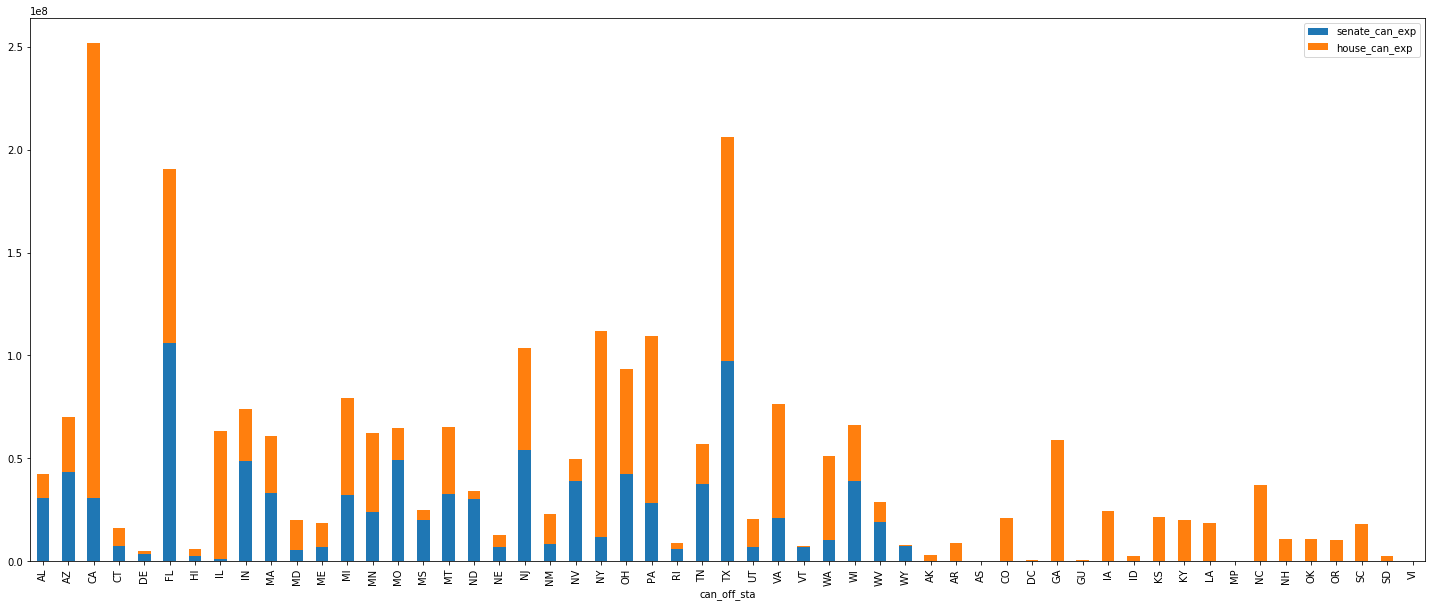

In [37]:
df_2018_main_h_filter = df_2018_main[df_2018_main['can_off']=='H'].groupby('can_off_sta')[['dis_amo']].\
                 sum().rename(columns={'dis_amo':'house_can_exp'})
df_2018_main_s_filter = df_2018_main[df_2018_main['can_off']=='S'].groupby('can_off_sta')[['dis_amo']].\
                 sum().rename(columns={'dis_amo':'senate_can_exp'})
df_2018_main_hs = df_2018_main_s_filter.merge(df_2018_main_h_filter, \
                                              left_on='can_off_sta', right_on='can_off_sta', how='outer')

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (25,10)
df_2018_main_hs.plot.bar(stacked=True) 
# unit of  y axis values: 100 million; orange-house; blue-senate

In [38]:
# 27 millions per state on average
df_2018_main_hs.house_can_exp.mean()
df_2018_main_hs.senate_can_exp.mean()

27335884.000363626

27114373.33771427

In [39]:
df_2018_main.head()

,can_id,can_nam,can_off,can_off_sta,dis_pur_des,cat_des,dis_amo,dis_purpose,networking,paycheck,eat,brain,advertising,operationcost,travel,finance,sum,win
0,H6AK00045,YOUNG-DONALD-E,H,AK,OFFICE JANITORIAL SERVICES,Unknown,300.0,office janitorial services,0,0,0,0,0,1,0,0,1,1
1,H6AK00045,YOUNG-DONALD-E,H,AK,PAYROLL TAXES,Unknown,3415.0,payroll taxes,0,1,0,0,0,0,0,0,1,1
2,H6AK00045,YOUNG-DONALD-E,H,AK,BANK CHARGE,Unknown,2.0,bank charge,0,0,0,0,0,1,0,0,1,1
3,H6AK00045,YOUNG-DONALD-E,H,AK,SIGN INSTALLATION,Unknown,7000.0,sign installation,0,0,0,0,1,0,0,0,1,1
4,H6AK00045,YOUNG-DONALD-E,H,AK,MAILING POSTAGE,Unknown,1394.5,mailing postage,0,0,0,0,0,1,0,0,1,1


In [40]:
df_2018_main_h = df_2018_main[df_2018_main['can_off'] == 'H'][['can_id', 'can_nam','dis_amo','networking', \
                                                               'paycheck', \
                'eat', 'brain', 'advertising', 'operationcost', 'travel', 'finance', 'win']]
df_2018_main_s = df_2018_main[df_2018_main['can_off'] == 'S'][['can_id', 'can_nam','dis_amo','networking', 'paycheck', \
                'eat', 'brain', 'advertising', 'operationcost', 'travel', 'finance', 'win']]
df_2018_main_h.head()
df_2018_main_s.head()

,can_id,can_nam,dis_amo,networking,paycheck,eat,brain,advertising,operationcost,travel,finance,win
0,H6AK00045,YOUNG-DONALD-E,300.0,0,0,0,0,0,1,0,0,1
1,H6AK00045,YOUNG-DONALD-E,3415.0,0,1,0,0,0,0,0,0,1
2,H6AK00045,YOUNG-DONALD-E,2.0,0,0,0,0,0,1,0,0,1
3,H6AK00045,YOUNG-DONALD-E,7000.0,0,0,0,0,1,0,0,0,1
4,H6AK00045,YOUNG-DONALD-E,1394.5,0,0,0,0,0,1,0,0,1


,can_id,can_nam,dis_amo,networking,paycheck,eat,brain,advertising,operationcost,travel,finance,win
33286,S6NJ00289,MENENDEZ-ROBERT,2373.8,0,1,0,0,0,0,0,0,1
33287,S6NJ00289,MENENDEZ-ROBERT,50.6,0,0,0,0,0,1,0,0,1
33288,S6NJ00289,MENENDEZ-ROBERT,3309.2,0,1,0,0,0,0,0,0,1
33291,S6NJ00289,MENENDEZ-ROBERT,15.0,0,0,0,0,0,1,0,0,1
33293,S6NJ00289,MENENDEZ-ROBERT,20.0,0,0,0,0,0,1,0,0,1


## <li>House representatives' expense pattern exploration

In [41]:
df_2018_main_h.can_id.nunique()
df_2018_main_h.can_nam.nunique()

2095

2093

In [42]:
df_2018_main_s.can_id.nunique()
df_2018_main_s.can_nam.nunique()

227

225

In [43]:
df_2018_main_h.head()
df_2018_main_s.head()

,can_id,can_nam,dis_amo,networking,paycheck,eat,brain,advertising,operationcost,travel,finance,win
0,H6AK00045,YOUNG-DONALD-E,300.0,0,0,0,0,0,1,0,0,1
1,H6AK00045,YOUNG-DONALD-E,3415.0,0,1,0,0,0,0,0,0,1
2,H6AK00045,YOUNG-DONALD-E,2.0,0,0,0,0,0,1,0,0,1
3,H6AK00045,YOUNG-DONALD-E,7000.0,0,0,0,0,1,0,0,0,1
4,H6AK00045,YOUNG-DONALD-E,1394.5,0,0,0,0,0,1,0,0,1


,can_id,can_nam,dis_amo,networking,paycheck,eat,brain,advertising,operationcost,travel,finance,win
33286,S6NJ00289,MENENDEZ-ROBERT,2373.8,0,1,0,0,0,0,0,0,1
33287,S6NJ00289,MENENDEZ-ROBERT,50.6,0,0,0,0,0,1,0,0,1
33288,S6NJ00289,MENENDEZ-ROBERT,3309.2,0,1,0,0,0,0,0,0,1
33291,S6NJ00289,MENENDEZ-ROBERT,15.0,0,0,0,0,0,1,0,0,1
33293,S6NJ00289,MENENDEZ-ROBERT,20.0,0,0,0,0,0,1,0,0,1


In [44]:
df_2018_main_h_networking = df_2018_main_h[df_2018_main_h.networking==1].groupby('can_nam')\
[['dis_amo']].sum().rename(columns={'dis_amo':'h_networking_exp'})
df_2018_main_h_paycheck = df_2018_main_h[df_2018_main_h.paycheck==1].groupby('can_nam')\
[['dis_amo']].sum().rename(columns={'dis_amo':'h_paycheck_exp'})
df_2018_main_h_eat = df_2018_main_h[df_2018_main_h.eat==1].groupby('can_nam')\
[['dis_amo']].sum().rename(columns={'dis_amo':'h_eat_exp'})
df_2018_main_h_brain = df_2018_main_h[df_2018_main_h.brain==1].groupby('can_nam')\
[['dis_amo']].sum().rename(columns={'dis_amo':'h_brain_exp'})
df_2018_main_h_advertising = df_2018_main_h[df_2018_main_h.advertising==1].groupby('can_nam')\
[['dis_amo']].sum().rename(columns={'dis_amo':'h_advertising_exp'})
df_2018_main_h_operationcost = df_2018_main_h[df_2018_main_h.operationcost==1].groupby('can_nam')\
[['dis_amo']].sum().rename(columns={'dis_amo':'h_operationcost_exp'})
df_2018_main_h_travel = df_2018_main_h[df_2018_main_h.travel==1].groupby('can_nam')\
[['dis_amo']].sum().rename(columns={'dis_amo':'h_travel_exp'})
df_2018_main_h_finance = df_2018_main_h[df_2018_main_h.finance==1].groupby('can_nam')\
[['dis_amo']].sum().rename(columns={'dis_amo':'h_finance_exp'})
df_2018_main_h_win = df_2018_main_h[df_2018_main_h.win==1].groupby('can_nam')\
[['win']].sum().rename(columns={'win':'h_winnerentries'})
df_2018_main_h_win['h_winner'] = df_2018_main_h_win.h_winnerentries.apply(lambda x: 1 if x>1 else 0)
df_2018_main_h_win.drop(columns='h_winnerentries',inplace=True)

In [45]:
df_2018_main_h_m1 = df_2018_main_h_networking.merge(df_2018_main_h_paycheck, \
                                              left_on='can_nam', right_on='can_nam', how='outer')
df_2018_main_h_m2 = df_2018_main_h_m1.merge(df_2018_main_h_eat, \
                                              left_on='can_nam', right_on='can_nam', how='outer')
df_2018_main_h_m3 = df_2018_main_h_m2.merge(df_2018_main_h_brain, \
                                              left_on='can_nam', right_on='can_nam', how='outer')
df_2018_main_h_m4 = df_2018_main_h_m3.merge(df_2018_main_h_advertising, \
                                              left_on='can_nam', right_on='can_nam', how='outer')
df_2018_main_h_m5 = df_2018_main_h_m4.merge(df_2018_main_h_operationcost, \
                                              left_on='can_nam', right_on='can_nam', how='outer')
df_2018_main_h_m6 = df_2018_main_h_m5.merge(df_2018_main_h_travel, \
                                              left_on='can_nam', right_on='can_nam', how='outer')
df_2018_main_h_m7 = df_2018_main_h_m6.merge(df_2018_main_h_finance, \
                                              left_on='can_nam', right_on='can_nam', how='outer')
df_2018_main_h_m8 = df_2018_main_h_m7.merge(df_2018_main_h_win, \
                                              left_on='can_nam', right_on='can_nam', how='outer')
df_2018_main_h_m = df_2018_main_h_m8.fillna(0)
len(df_2018_main_h_m)

2093

In [46]:
Y = df_2018_main_h_m.h_winner
X = df_2018_main_h_m.drop('h_winner', axis=1)
dt=tree.DecisionTreeClassifier(max_depth=1)
dt.fit(X,Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

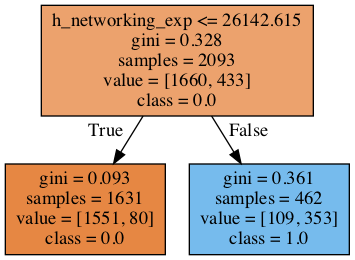

In [47]:
dt_feature_names = list(X.columns)
dt_target_names = [str(s) for s in Y.unique()]
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

In [48]:
df_2018_main_h_m.h_networking_exp.describe()

count    2.1e+03
mean     4.2e+04
std      1.5e+05
min      0.0e+00
25%      0.0e+00
50%      2.5e+03
75%      2.0e+04
max      3.9e+06
Name: h_networking_exp, dtype: float64

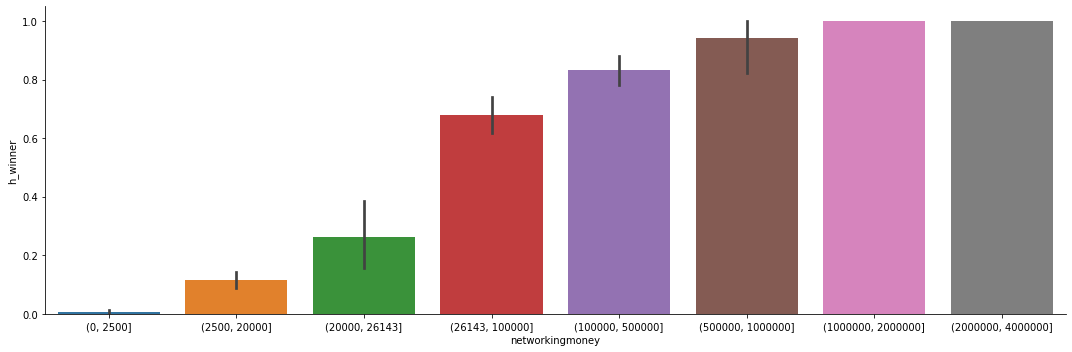

In [75]:
df_2018_main_h_m['networkingmoney']=pd.cut(df_2018_main_h_m.h_networking_exp, \
                                           bins=(0,2500,20000,26143,100000, 500000,1000000, 2000000,4000000))
sns.factorplot(x='networkingmoney', y='h_winner', kind = 'bar', data=df_2018_main_h_m, aspect=3)

In [50]:
df_2018_main_h_m.head()

,h_networking_exp,h_paycheck_exp,h_eat_exp,h_brain_exp,h_advertising_exp,h_operationcost_exp,h_travel_exp,h_finance_exp,h_winner,networkingmoney
can_nam,,,,,,,,,,
AARESTAD-DAVID,3000.0,113941.0,0.0,44245.6,6903.0,12937.6,660.2,0.0,0.0,"(2500, 20000]"
ABDULAHI-JAMAL-MR.,14305.4,0.0,887.8,5128.3,2600.0,50524.8,1760.1,0.0,0.0,"(2500, 20000]"
ABEL-KEVIN,3416.8,83290.8,5193.6,68858.8,565480.8,71593.7,1166.6,8899.5,0.0,"(2500, 20000]"
ABRAHAM-RALPH-LEE-DR.-JR.,104094.7,0.0,7363.8,373937.2,387936.0,37619.5,11799.1,94095.4,1.0,"(100000, 500000]"
ABROMS-DAVID,3963.8,0.0,0.0,167488.6,49256.2,33837.3,7728.0,0.0,0.0,"(2500, 20000]"


In [51]:
df_2018_main_h_m.h_networking_exp.sum() # 88.3 millions$

88291281.65

In [52]:
df_2018_main_h_m.h_paycheck_exp.sum() # 151.3 millions$

151327111.22

In [53]:
df_2018_main_h_m.h_eat_exp.sum() # 9 millions$

9017008.74

In [54]:
df_2018_main_h_m.h_brain_exp.sum() # 202.1 millions$

202143112.62

In [55]:
df_2018_main_h_m.h_advertising_exp.sum() # 693.5 millions$

693478394.56

In [56]:
df_2018_main_h_m.h_operationcost_exp.sum() # 158.4 millions$

158355931.14

In [57]:
df_2018_main_h_m.h_travel_exp.sum() # 42.1 millions$

42058259.64

In [58]:
df_2018_main_h_m.h_finance_exp.sum() # 158.8 millions$

158802520.45

### <div class="alert alert-block alert-warning"><li>Conclusion and Managerial Insight<br><br>From the decision tree and chart above, we could see that networking is the most critical factor to winning the House election. To secure the election result, at least half a million should be spent on networking activities such as event, gift, donation etc.<br><br>When compared with the expense totals of each category, we find that even thought advertising costs the most in a campaign trial, it's not the critical factor of a candidats's winning!<br><br>For candidates running for an M.H.R. seat, the best strategy is to spend about 1 million dollars on networking and try to cut down advertising cost, think tank cost and operation cost.

## <li>Senate candidates' expense pattern exploration

In [59]:
df_2018_main_s_networking = df_2018_main_s[df_2018_main_s.networking==1].groupby('can_nam')\
[['dis_amo']].sum().rename(columns={'dis_amo':'s_networking_exp'})
df_2018_main_s_paycheck = df_2018_main_s[df_2018_main_s.paycheck==1].groupby('can_nam')\
[['dis_amo']].sum().rename(columns={'dis_amo':'s_paycheck_exp'})
df_2018_main_s_eat = df_2018_main_s[df_2018_main_s.eat==1].groupby('can_nam')\
[['dis_amo']].sum().rename(columns={'dis_amo':'s_eat_exp'})
df_2018_main_s_brain = df_2018_main_s[df_2018_main_s.brain==1].groupby('can_nam')\
[['dis_amo']].sum().rename(columns={'dis_amo':'s_brain_exp'})
df_2018_main_s_advertising = df_2018_main_s[df_2018_main_s.advertising==1].groupby('can_nam')\
[['dis_amo']].sum().rename(columns={'dis_amo':'s_advertising_exp'})
df_2018_main_s_operationcost = df_2018_main_s[df_2018_main_s.operationcost==1].groupby('can_nam')\
[['dis_amo']].sum().rename(columns={'dis_amo':'s_operationcost_exp'})
df_2018_main_s_travel = df_2018_main_s[df_2018_main_s.travel==1].groupby('can_nam')\
[['dis_amo']].sum().rename(columns={'dis_amo':'s_travel_exp'})
df_2018_main_s_finance = df_2018_main_s[df_2018_main_s.finance==1].groupby('can_nam')\
[['dis_amo']].sum().rename(columns={'dis_amo':'s_finance_exp'})
df_2018_main_s_win = df_2018_main_s[df_2018_main_s.win==1].groupby('can_nam')\
[['win']].sum().rename(columns={'win':'s_winnerentries'})
df_2018_main_s_win['s_winner'] = df_2018_main_s_win.s_winnerentries.apply(lambda x: 1 if x>1 else 0)
df_2018_main_s_win.drop(columns='s_winnerentries',inplace=True)

In [60]:
df_2018_main_s_m1 = df_2018_main_s_networking.merge(df_2018_main_s_paycheck, \
                                              left_on='can_nam', right_on='can_nam', how='outer')
df_2018_main_s_m2 = df_2018_main_s_m1.merge(df_2018_main_s_eat, \
                                              left_on='can_nam', right_on='can_nam', how='outer')
df_2018_main_s_m3 = df_2018_main_s_m2.merge(df_2018_main_s_brain, \
                                              left_on='can_nam', right_on='can_nam', how='outer')
df_2018_main_s_m4 = df_2018_main_s_m3.merge(df_2018_main_s_advertising, \
                                              left_on='can_nam', right_on='can_nam', how='outer')
df_2018_main_s_m5 = df_2018_main_s_m4.merge(df_2018_main_s_operationcost, \
                                              left_on='can_nam', right_on='can_nam', how='outer')
df_2018_main_s_m6 = df_2018_main_s_m5.merge(df_2018_main_s_travel, \
                                              left_on='can_nam', right_on='can_nam', how='outer')
df_2018_main_s_m7 = df_2018_main_s_m6.merge(df_2018_main_s_finance, \
                                              left_on='can_nam', right_on='can_nam', how='outer')
df_2018_main_s_m8 = df_2018_main_s_m7.merge(df_2018_main_s_win, \
                                              left_on='can_nam', right_on='can_nam', how='outer')
df_2018_main_s_m = df_2018_main_s_m8.fillna(0)
len(df_2018_main_s_m)

225

In [61]:
Y = df_2018_main_s_m.s_winner
X = df_2018_main_s_m.drop('s_winner', axis=1)
dt=tree.DecisionTreeClassifier(max_depth=1)
dt.fit(X,Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

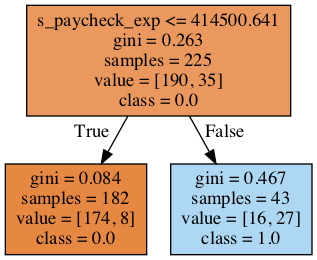

In [62]:
dt_feature_names = list(X.columns)
dt_target_names = [str(s) for s in Y.unique()]
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

In [63]:
df_2018_main_s_m.s_paycheck_exp.describe()

count    2.2e+02
mean     3.9e+05
std      1.2e+06
min      0.0e+00
25%      0.0e+00
50%      2.4e+02
75%      2.1e+05
max      1.4e+07
Name: s_paycheck_exp, dtype: float64

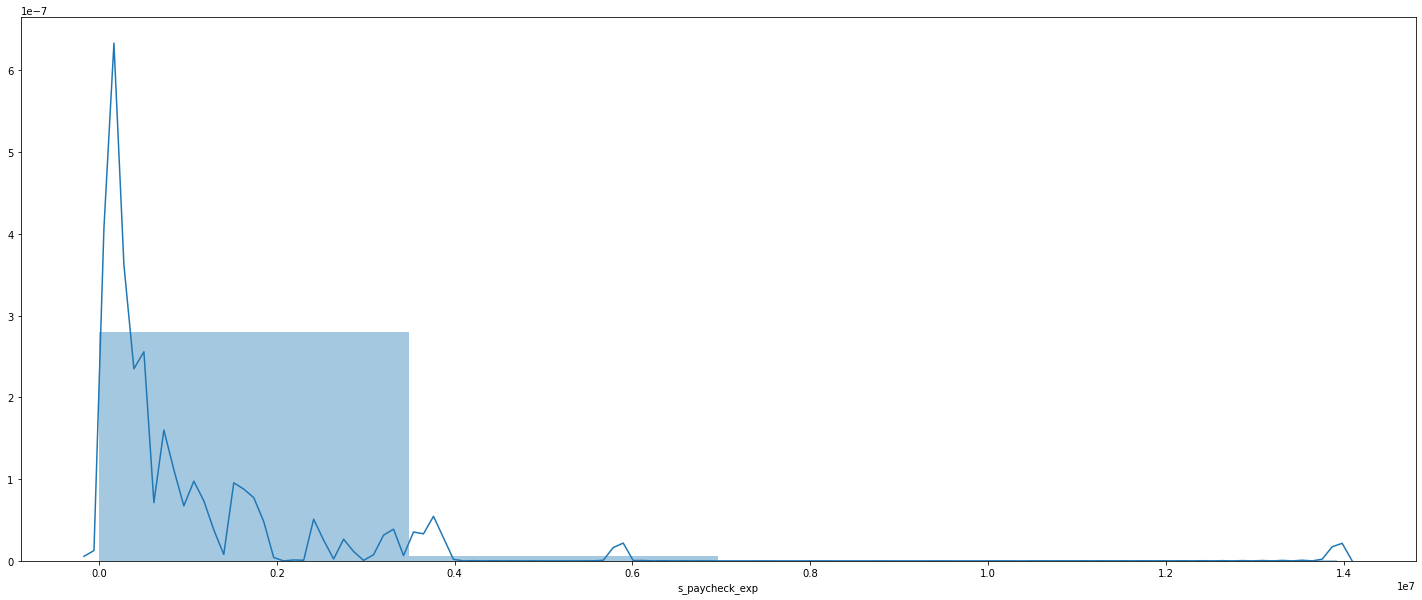

In [64]:
sns.distplot(df_2018_main_s_m.s_paycheck_exp, bins=4)

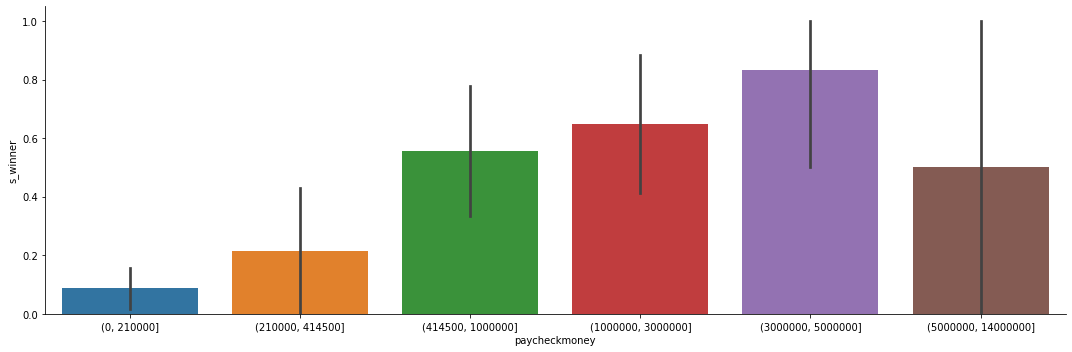

In [65]:
df_2018_main_s_m['paycheckmoney']=pd.cut(df_2018_main_s_m.s_paycheck_exp, \
                                           bins=(0,210000,414500,1000000,3000000,5000000,14000000))
sns.factorplot(x='paycheckmoney', y='s_winner', kind = 'bar', data=df_2018_main_s_m, aspect=3)

In [66]:
df_2018_main_s_m.head()

,s_networking_exp,s_paycheck_exp,s_eat_exp,s_brain_exp,s_advertising_exp,s_operationcost_exp,s_travel_exp,s_finance_exp,s_winner,paycheckmoney
can_nam,,,,,,,,,,
ABBOUD-DEEDRA,5.0e+03,0.0e+00,196.5,9.8e+03,3.5e+04,3.9e+04,1148.0,3.9e+03,0.0,NaN
ARPAIO-JOE,5.0e+02,0.0e+00,3246.3,1.6e+06,6.4e+04,6.7e+05,6962.7,4.2e+05,0.0,NaN
AYERS-CYNTHIA-ELLEN,1.2e+03,0.0e+00,264.0,0.0e+00,2.8e+03,9.0e+03,100.0,0.0e+00,0.0,NaN
AYYADURAI-SHIVA--DR,1.8e+06,8.0e+05,1352.8,4.5e+04,4.0e+04,1.1e+05,5297.1,0.0e+00,0.0,"(414500.0, 1000000.0]"
BALDWIN-TAMMY,1.4e+05,5.8e+06,2562.0,7.0e+05,1.8e+07,1.1e+06,95992.4,4.4e+06,1.0,"(5000000.0, 14000000.0]"


In [67]:
df_2018_main_s_m.s_networking_exp.sum() # 21.4 millions$

21408619.690000005

In [68]:
df_2018_main_s_m.s_paycheck_exp.sum() # 88.1 millions$

88087126.21000013

In [69]:
df_2018_main_s_m.s_eat_exp.sum() # 1.9 millioins$

1871219.4999999998

In [70]:
df_2018_main_s_m.s_brain_exp.sum() # 96.2 millions$

96204947.94999999

In [71]:
df_2018_main_s_m.s_advertising_exp.sum() # 561.0 millions$

560920300.37

In [72]:
df_2018_main_s_m.s_operationcost_exp.sum() #78.2 millions$

78198938.74999999

In [73]:
df_2018_main_s_m.s_travel_exp.sum() # 21.9 millions$

21901165.129999973

In [74]:
df_2018_main_s_m.s_finance_exp.sum() # 80.4 millions$

80410749.22

### <div class="alert alert-block alert-warning"><li>Conclusion and Managerial Insight<br><br>From the decision tree and chart above, we could see that staff paycheck is the most critical factor to winning the Senate election. To secure the election result, at least 500 thousand dollars should be spent on campaign team paychecks; 3-5 millions could be the most suitable budget. And it's not that the more staff you hire, the better the election result gets. Clearly the campaign team should be kept at a reasonable size. Any candidate spends more than 5 million dollars on paycheck could think of downsizing his/her team.